# Loan Prediction

in this project, a machine learning model would develop a model for predicting wether a person can recieve a bank loan or not. I will be using pytorch's framework for this project.

## Import Needed Libraries

In [ ]:
# Basic Python Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import seaborn as sns
import os

# for text correction
from autocorrect import Speller

# preprocessing libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import GridSearchCV

# ML Libraries
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# for cleaner notebook
from tqdm import tqdm

## EDA

The data that will be used is a Loan data whether a person is given the loan or not
<table>
<tr>
<th>Column Name</th>
<th>Description</th>
</tr>
<tr>
<td>person_age</td>
<td>The age of the person</td>
</tr>
<tr>
<td>person_gender</td>
<td>The gender of the person</td>
</tr>
<tr>
<td>person_education</td>
<td>Last Education</td>
</tr>
<tr>
<td>person_income</td>
<td>Person income in a year</td>
</tr>
<tr>
<td>person_emp_exp</td>
<td>Tahun pengalaman bekerja</td>
</tr>
<tr>
<td>person_home_ownership</td>
<td>The status of ownership of a home</td>
</tr>
<tr>
<td>loan_amnt</td>
<td>The amount of loan that is asked</td>
</tr>
<tr>
<td>loan_intent</td>
<td>The purpose of the loan</td>
</tr>
<tr>
<td>loan_int_rate</td>
<td>Interest rate of the loan</td>
</tr>
<tr>
<td>loan_percent_income</td>
<td>The amount of the loan as a percentage form yearly income</td>
</tr>
<tr>
<td>cb_person_cred_hist_length</td>
<td>Credit duration in one year</td>
</tr>
<tr>
<td>credit_score</td>
<td>The credit score of the person</td>
</tr>
<tr>
<td>previous_loan_defaults_on_file</td>
<td>Previous loan delinquency indicators</td>
</tr>
<tr>
<td>loan_status (target variable)</td>
<td>Loan Approval; 1: Accepted dan 0: Rejected</td>
</tr>
</table>

In [50]:
#import the data
data = pd.read_csv("loan.csv")

In [51]:
data.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   42750 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

In [53]:
is_na = pd.DataFrame(data.isna().sum())
is_na.columns = ['missing_count']
is_na['missing_percent'] = is_na['missing_count'] / len(data) * 100
is_na

,missing_count,missing_percent
person_age,0,0.0
person_gender,0,0.0
person_education,0,0.0
person_income,2250,5.0
person_emp_exp,0,0.0
person_home_ownership,0,0.0
loan_amnt,0,0.0
loan_intent,0,0.0
loan_int_rate,0,0.0
loan_percent_income,0,0.0


Turns out there are 2250 of the person income data that is missing. Therefore we need to inspect if it just needs to be deleted or filled with average or median of the data.

### Plotting functions

In [54]:
#setting the colors generator
def fill_color_generator():
    """This generates a color

    Returns:
        color: An R,G,B value with a range of 0 to 1
    """
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    return (r/255, g/255, b/255)

In [55]:
#function for plotting numerical data distribution
def numeric_dist_plot(data: pd.DataFrame):
    """This function creates a plot of the distribution of the numerical data. 

    Args:
        data (pd.DataFrame): Numeric pandas dataframe

    Raises:
        TypeError: The following columns are not numeric: {non_numeric_cols}
        This is due to some of the columns are not numeric.

    Returns:
        Displays a plot of
    """
    # Checks
    ## Check if all columns are numeric
    non_numeric_cols = [col for col in data.columns if not pd.api.types.is_numeric_dtype(data[col])]
    if non_numeric_cols:
        raise TypeError(f"The following columns are not numeric: {non_numeric_cols}")
    
    # Plotting the numerical data
    #titles for plots/figures
    fig_titles = []

    for colName in data.columns:
        fig_titles.append(f"Boxplot Of {colName}")
        fig_titles.append(f"Histogram Of {colName}")
        
    fill_color_dict = {}
    for colName in data.columns:
        fill_color_dict[colName] = fill_color_generator()

    # make subplot for each column name
    num_rows = len(data.columns)
    fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, num_rows * 3))

    # Flatten axes for easier indexing when there's more than 1 row
    axes = axes if num_rows > 1 else [axes]

    for i, column in enumerate(data.columns):
        color = fill_color_dict[column]

        # Boxplot
        axes[i][0].boxplot(data[column].dropna(), vert=False, patch_artist=True,
                        boxprops=dict(facecolor=color, color=color),
                        medianprops=dict(color="black"))
        axes[i][0].set_title(f"Boxplot of {column}")
        axes[i][0].set_xlabel(column)

        # Histogram
        axes[i][1].hist(data[column].dropna(), bins=20, color=color, alpha=0.7, edgecolor='black')
        axes[i][1].set_title(f"Histogram of {column}")
        axes[i][1].set_xlabel(column)

    # Overall layout
    fig.suptitle("Boxplot and Distribution Visualization for Each Numeric Column", fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout to fit title
    return plt

In [56]:
#function for plotting categorical data distribution
def categoric_dist_plot(data: pd.DataFrame):
    """_summary_

    Args:
        data (pd.DataFrame): Categorical pandas dataframe

    Raises:
        TypeError: The following columns are not categorical: {non_numeric_cols}
        This is due to some of the columns are not categorical.

    Returns:
        plt: Plot of the categorical data distribution
    """
    # Checks
    ## Check if all columns are numeric
    non_categoric_cols = [col for col in data.columns if pd.api.types.is_numeric_dtype(data[col])]
    if non_categoric_cols:
        raise TypeError(f"The following columns are not categoric: {non_categoric_cols}")

    # Create subplots: one row for each categorical column
    num_rows = len(data.columns)
    fig, axes = plt.subplots(nrows=num_rows, ncols=1, figsize=(10, num_rows * 3), sharex=False)

    # Flatten axes for easier handling if there's more than 1 row
    axes = axes if num_rows > 1 else [axes]

    # Plot each categorical distribution
    for i, col in enumerate(data.columns):
        counts = data[col].value_counts(dropna=False)  # Get the count values
        counts.index = counts.index.astype(str) #convert the categorical values to strings since there are numerical categories
        
        #Create the bar plot
        axes[i].bar(counts.index, counts)
        
        # Set title and labels
        axes[i].set_title(f"Distribution of {col}", fontsize=12)
        axes[i].set_ylabel("Count")
        axes[i].set_xlabel("Category")
        
        # Rotate x-axis labels for better readability
        axes[i].tick_params(axis='x', rotation=90)

    # Add an overall title and adjust layout
    fig.suptitle("Bar Plots for Categorical Columns", fontsize=16, y=1.02)
    fig.tight_layout(h_pad=2.0)  # Adjust spacing between rows
    return plt

### Split data to categorical and numerical

In [57]:
categorical_data = data.select_dtypes(exclude=[np.number])
numerical_data = data.select_dtypes(include=[np.number])

### Plotting

#### numerical data distribution

<module 'matplotlib.pyplot' from 'c:\\Users\\Panther\\anaconda3\\envs\\pytorch_env\\Lib\\site-packages\\matplotlib\\pyplot.py'>

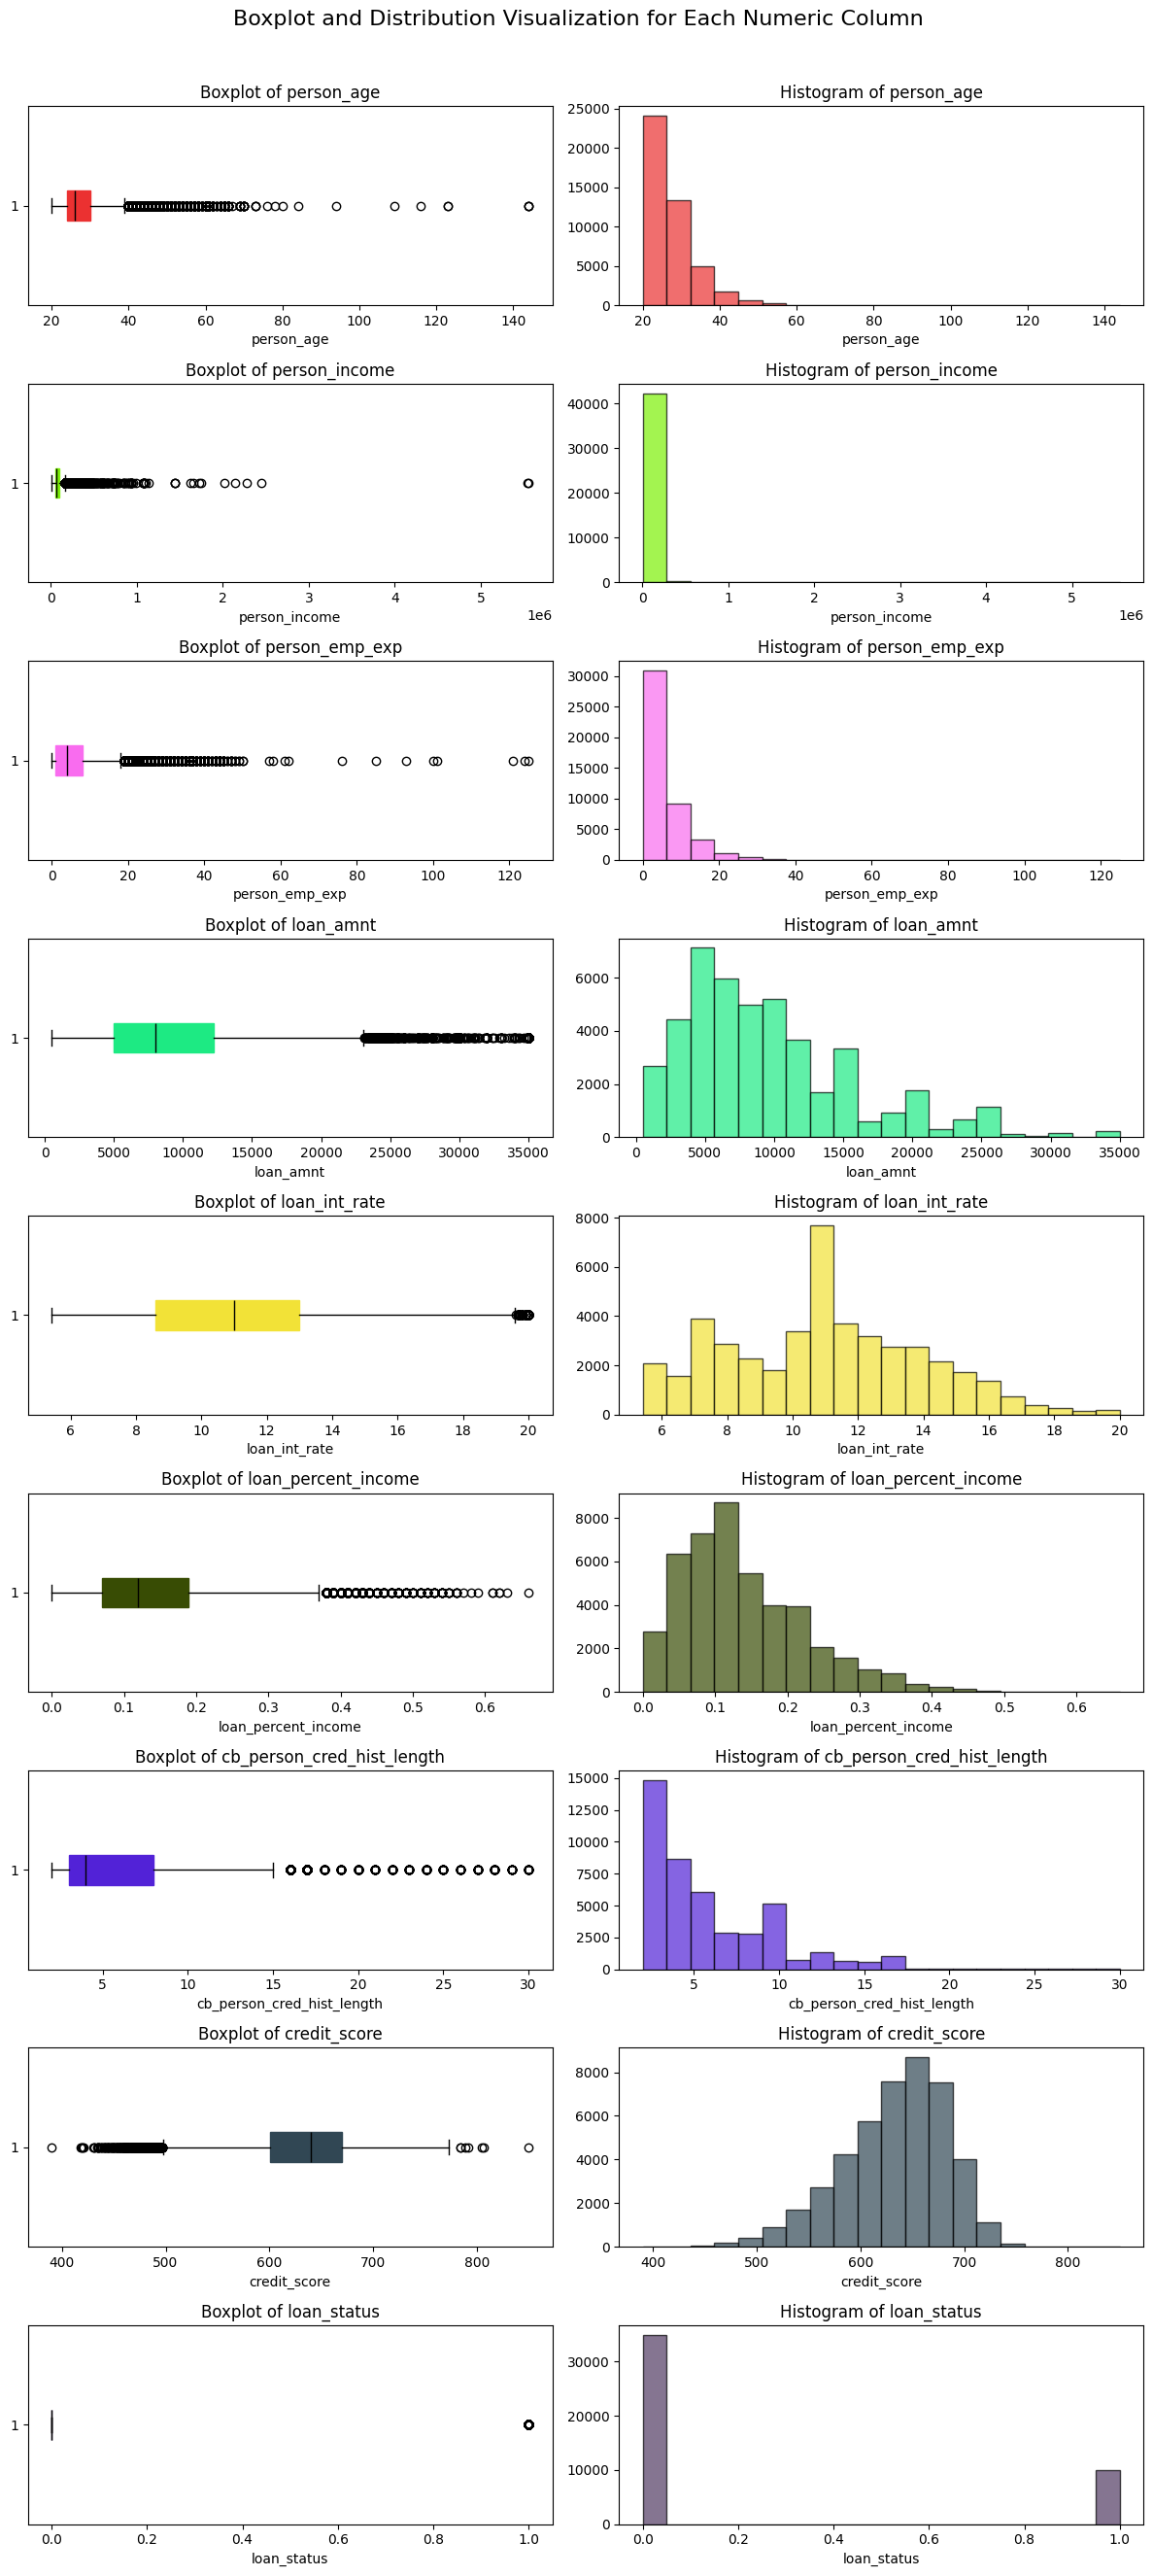

In [58]:
numeric_dist_plot(numerical_data)

#### Categorical data distribution

<module 'matplotlib.pyplot' from 'c:\\Users\\Panther\\anaconda3\\envs\\pytorch_env\\Lib\\site-packages\\matplotlib\\pyplot.py'>

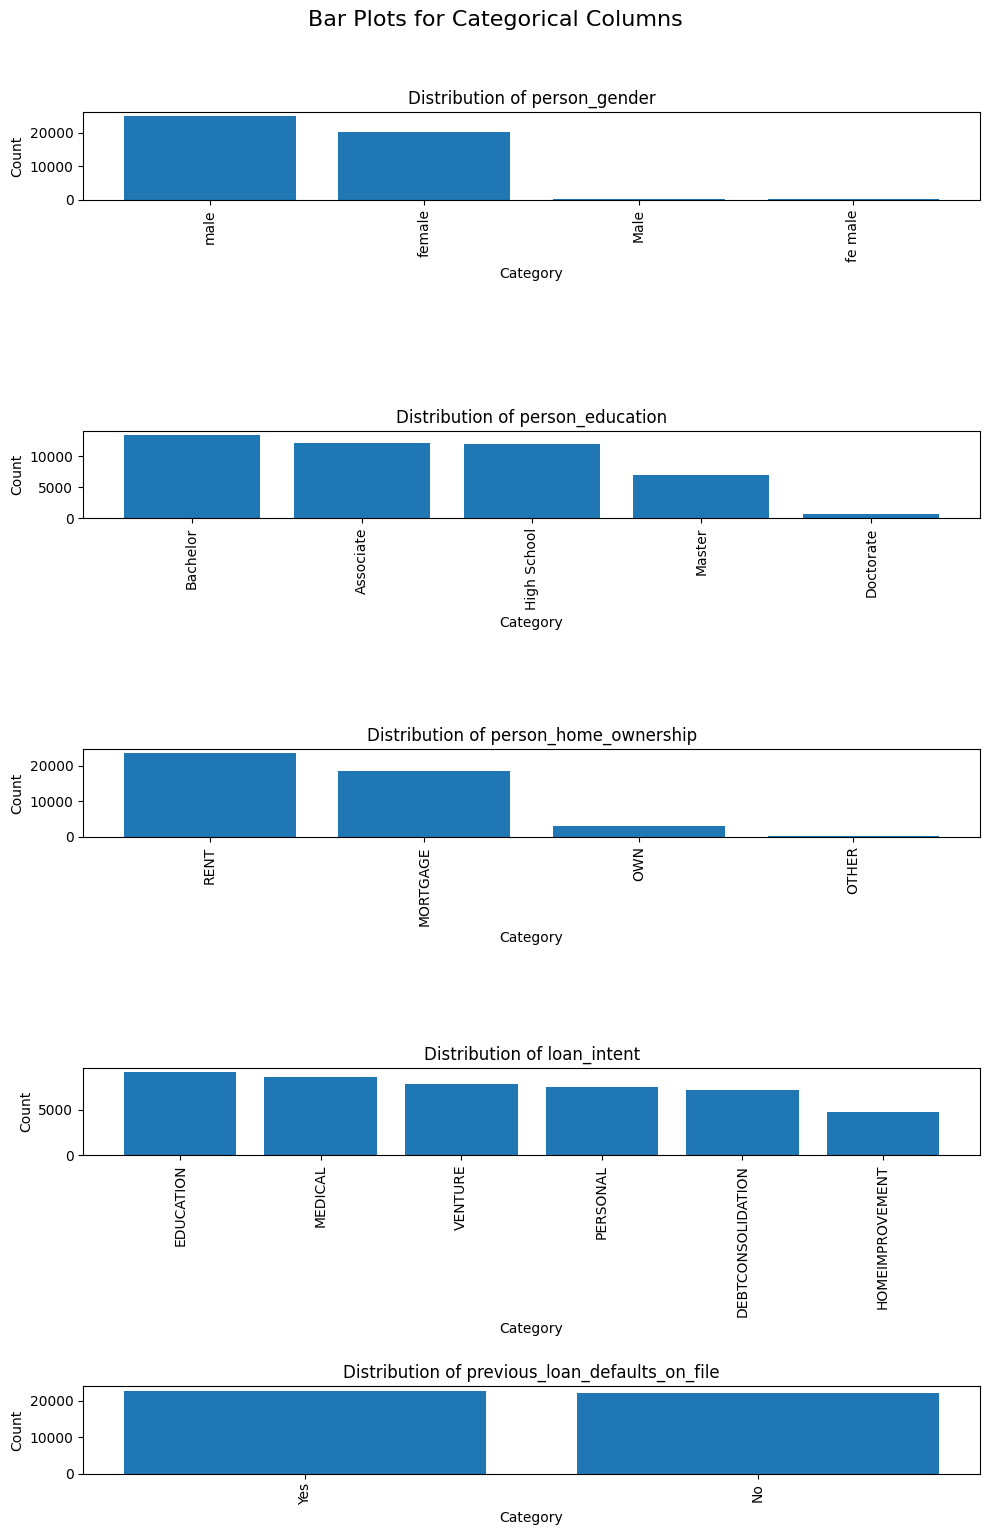

In [59]:
categoric_dist_plot(categorical_data)

## Data Cleaning

### Fix the gender inconsistency

#### function to standardize the genders values

In [60]:
def str_corrector(text: str):
    
    if not isinstance(text, str):
        raise ValueError("Input must be a string")
    
    # standardize the text to lowercase and strip additional empty spaces
    text = text.lower().strip()
    
    #correvt the text using the autocorrect library
    corrector = Speller(lang='en')
    corrected_text = corrector(text)

    return corrected_text

In [61]:
import pickle
def save_cache(data, filename):
    """This is a function to save the data to a file using pickle

    Args:
        data (_type_): data to be saved
        filename (_type_): the name of the file to save the data to
    """
    with open(filename, 'wb') as f:
        pickle.dump(data, f)
    print(f"Data saved to {filename}")

def load_cache(filename):
    """This is a function to load the data to a file using pickle

    Args:
        data (_type_): data to be saved
        filename (_type_): the name of the file to load the data to
    """
    with open(filename, 'rb') as f:
        return pickle.load(f)
    print(f"Data loaded from {filename}")

In [62]:
#load the cached data if it exists
if os.path.exists("cached_dataset.pkl"):
    data = load_cache("cached_dataset.pkl")
else:
    #this enables the progress bar for the text correction
    tqdm.pandas(desc="Correcting Text")
    data["person_gender"] = tqdm(data["person_gender"].progress_apply(str_corrector))
    save_cache(data, "cached_dataset.pkl")


In [63]:
#check the data again
data.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


### Fix missing values

As previously seen in the EDA, there are 2250 number of data that is missing in the `person_income` column. even though it is 5% of the data, it is 

In [64]:
data_missing = (data[data.isna().any(axis=1)])
len(data_missing)

2250

In [65]:
data["person_income"] = data["person_income"].fillna(data["person_income"].mean())

## Preprocessing
for preprocessing the data, we just need to encode the data and no need to scale the data. Due to this is a tree based algorithm, it is robust towards outliers and no need scaling.

### Train test split

In [66]:
x = data.drop(columns=["loan_status"])
y = data["loan_status"]
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=42)

In [67]:
len(train_y), len(train_x)

(36000, 36000)

### Encoding the data

In [68]:
gender_enc =  LabelEncoder()
education_enc = OrdinalEncoder(categories=[['High School', 'Associate', 'Bachelor', 'Master', 'Doctorate']], handle_unknown="use_encoded_value", unknown_value=-1).set_output(transform="pandas") # education would be encoded as ordinal data since there is a hierarical relationship between the categories
home_ownership_enc = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
loan_intent_enc = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
previous_loans_enc = LabelEncoder()


In [69]:
train_x["person_education"].unique()

array(['Bachelor', 'High School', 'Master', 'Associate', 'Doctorate'],
      dtype=object)

In [70]:
train_x.columns

Index(['person_age', 'person_gender', 'person_education', 'person_income',
       'person_emp_exp', 'person_home_ownership', 'loan_amnt', 'loan_intent',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
       'credit_score', 'previous_loan_defaults_on_file'],
      dtype='object')

### Apply the encoder

#### Apply to train data

In [71]:
# encoding the categorical variables
train_gender_encoded = pd.DataFrame(gender_enc.fit_transform(train_x["person_gender"]))
train_gender_encoded.columns = ["gender"]

train_home_ownership_encoded = pd.DataFrame(home_ownership_enc.fit_transform(train_x[["person_home_ownership"]]))
train_home_ownership_encoded.columns = home_ownership_enc.get_feature_names_out(["person_home_ownership"])

train_loan_intent_encoded = loan_intent_enc.fit_transform(train_x[["loan_intent"]])
train_loan_intent_encoded.columns = loan_intent_enc.get_feature_names_out(["loan_intent"])

train_prev_loans_encoded = pd.DataFrame(previous_loans_enc.fit_transform(train_x["previous_loan_defaults_on_file"]))
train_prev_loans_encoded.columns = ['previous_loan_default']

train_education_encoded = pd.DataFrame(education_enc.fit_transform(train_x[["person_education"]]))
train_education_encoded.columns = ['education_level']

In [72]:
len(train_gender_encoded), len(train_home_ownership_encoded), len(train_loan_intent_encoded), len(train_prev_loans_encoded), len(train_education_encoded)

(36000, 36000, 36000, 36000, 36000)

In [73]:
#combine all the data and drop the original columns
train_x = pd.concat([train_x.drop(columns=["person_gender", "person_home_ownership", "loan_intent", "previous_loan_defaults_on_file", "person_education"]).reset_index(drop=True),
                     train_gender_encoded.reset_index(drop=True),
                     train_home_ownership_encoded.reset_index(drop=True),
                     train_loan_intent_encoded.reset_index(drop=True),
                     train_prev_loans_encoded.reset_index(drop=True),
                     train_education_encoded.reset_index(drop=True)], axis=1)

In [74]:
train_x

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,gender,person_home_ownership_MORTGAGE,...,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,previous_loan_default,education_level
0,34.0,97265.000000,11,15000.0,12.73,0.15,9.0,631,1,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,2.0
1,25.0,80182.226222,3,12000.0,11.86,0.16,4.0,659,2,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0.0
2,41.0,322597.000000,18,24000.0,10.37,0.07,11.0,683,1,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,3.0
3,27.0,94232.000000,4,9600.0,17.14,0.10,7.0,641,2,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1.0
4,27.0,80182.226222,7,7059.0,12.97,0.08,3.0,706,2,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35995,26.0,80182.226222,6,10625.0,6.03,0.12,4.0,559,2,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0.0
35996,25.0,34772.000000,3,5876.0,11.69,0.17,4.0,647,1,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0
35997,33.0,58317.000000,9,10707.0,10.74,0.18,9.0,652,1,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1.0
35998,26.0,178602.000000,6,20000.0,17.99,0.11,3.0,604,2,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,3.0


In [75]:
len(train_y), len(train_x)

(36000, 36000)

#### Apply to test data

In [76]:
# encoding the categorical variables
test_gender_encoded = pd.DataFrame(gender_enc.transform(test_x["person_gender"]))
test_gender_encoded.columns = ["gender"]

test_home_ownership_encoded = pd.DataFrame(home_ownership_enc.transform(test_x[["person_home_ownership"]]))
test_home_ownership_encoded.columns = home_ownership_enc.get_feature_names_out(["person_home_ownership"])

test_loan_intent_encoded = loan_intent_enc.transform(test_x[["loan_intent"]])
test_loan_intent_encoded.columns = loan_intent_enc.get_feature_names_out(["loan_intent"])

test_prev_loans_encoded = pd.DataFrame(previous_loans_enc.transform(test_x["previous_loan_defaults_on_file"]))
test_prev_loans_encoded.columns = ['previous_loan_default']

test_education_encoded = pd.DataFrame(education_enc.transform(test_x[["person_education"]]))
test_education_encoded.columns = ['education_level']

In [77]:
#combine all the data and drop the original columns
test_x = pd.concat([test_x.drop(columns=["person_gender", "person_home_ownership", "loan_intent", "previous_loan_defaults_on_file", "person_education"]).reset_index(drop=True),
                     test_gender_encoded.reset_index(drop=True),
                     test_home_ownership_encoded.reset_index(drop=True),
                     test_loan_intent_encoded.reset_index(drop=True),
                     test_prev_loans_encoded.reset_index(drop=True),
                     test_education_encoded.reset_index(drop=True)], axis=1)

## Model Training

### Random forest model

In [78]:
#Grid search setup
rf_grid = RandomForestClassifier()
gr_space = {
    "n_estimators": [100, 200, 300],  # number of trees
    "max_depth": [None, 10, 20, 30],  # tree depth
    "min_samples_split": [2, 5, 10],  # min samples to split a node
    "min_samples_leaf": [1, 2, 4],    # min samples at leaf
    "max_features": ['auto', 'sqrt', 'log2'],  # features considered at each split
    "bootstrap": [True, False],       # whether bootstrap samples are used
    "class_weight": [None, 'balanced'],  # helpful if your classes are imbalanced
}

rf_model_grid = GridSearchCV(rf_grid,
                             gr_space,
                             cv = 3,
                             scoring='f1_macro',
                             verbose = 3,
                             n_jobs=-1 #all cores
                             )

In [79]:
#flatten the y_train
train_y = train_y.values.ravel()

In [80]:
# rf_model_result = rf_model_grid.fit(train_x, train_y) #grid search in colab

In [81]:
# rf_best_params = rf_model_result.best_params_
# print("Grid search result for optimal parameters: ")
# for param in sorted(rf_best_params.keys()):
#     print(f"{param}: {rf_best_params[param]}")

#### Best Model Results (after grid search)
Grid search result for optimal parameters: <br>
bootstrap: False <br>
class_weight: balanced <br>
max_depth: None <br>
max_features: log2 <br>
min_samples_leaf: 2 <br>
min_samples_split: 2 <br>
n_estimators: 100<br>

#### Retrain best model

In [82]:
random_foret_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=2,
    max_features="log2",
    bootstrap=False,
    class_weight="balanced"
)

In [83]:
random_foret_model.fit(train_x, train_y)

RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       max_features='log2', min_samples_leaf=2)

#### Test the Model

In [84]:
random_forest_predictions = random_foret_model.predict(test_x)

#### Model Evaluation

In [86]:
print(classification_report(test_y, random_forest_predictions))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95      6990
           1       0.86      0.81      0.83      2010

    accuracy                           0.93      9000
   macro avg       0.90      0.89      0.89      9000
weighted avg       0.93      0.93      0.93      9000



We will be looking at the weighted average since our classes are imbalanced. Since the weighted average of the f1_score, recall, and precision are 0.93 or 93% it shows that the models performs very well even though there are class imbalances.

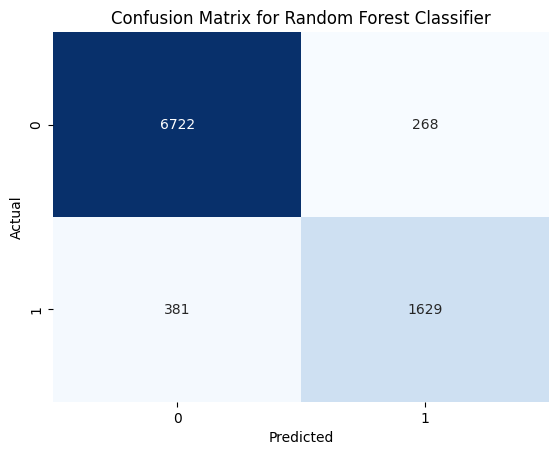

In [87]:
confusion_matrix_result = confusion_matrix(test_y, random_forest_predictions)
sns.heatmap(confusion_matrix_result, 
            annot=True, 
            fmt='d', 
            cmap='Blues', 
            cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()

### XGBoost Classifier Model

In [88]:
#Grid search setup
xgb_grid = XGBClassifier()
xgb_grid_search_space = {
    "n_estimators": [100, 200, 300],           # Number of trees
    "max_depth": [3, 5, 7, 10],                # Max depth of a tree
    "learning_rate": [0.01, 0.1, 0.2, 0.3],    # Step size shrinkage
    "subsample": [0.6, 0.8, 1.0],              # Fraction of rows to use per tree
    "colsample_bytree": [0.6, 0.8, 1.0],       # Fraction of columns to use per tree
    "gamma": [0, 1, 5],                        # Minimum loss reduction required to split
    "reg_alpha": [0, 0.1, 1],                  # L1 regularization
    "reg_lambda": [1, 5, 10],                  # L2 regularization
    "scale_pos_weight": [1, 2, 5],             # To balance positive/negative weights
}


xgb_model_grid = GridSearchCV(xgb_grid,
                             xgb_grid_search_space,
                             cv = 3,
                             scoring='f1_macro',
                             verbose = 3,
                             n_jobs=-1 #all cores
                             )

In [89]:
# xgb_model_result = xgb_model_grid.fit(train_x, train_y) #grid search in colab

In [90]:
# xgb_best_params = xgb_model_result.best_params_
# print("Grid search result for optimal parameters: ")
# for param in sorted(xgb_best_params.keys()):
#     print(f"{param}: {xgb_best_params[param]}")

#### Best Model Results (after grid search)

Grid search result for optimal parameters: <br>
colsample_bytree: 0.8 <br>
gamma: 0 <br>
learning_rate: 0.1 <br>
max_depth: 5 <br>
n_estimators: 300 <br>
reg_alpha: 0 <br>
reg_lambda: 1 <br>
scale_pos_weight: 1 <br>
subsample: 0.8 <br>

#### Retrain best model

In [91]:
xgb_classifier_model = XGBClassifier(
    colsample_bytree=0.8,
    gamma=0,
    learning_rate=0.1,
    max_depth=5,
    n_estimators=300,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    subsample=0.8
)

In [92]:
xgb_classifier_model.fit(train_x, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, ...)

#### Test the Model

In [93]:
xgb_model_predictions = xgb_classifier_model.predict(test_x)

#### Model Evaluation

In [95]:
print(classification_report(test_y, xgb_model_predictions))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96      6990
           1       0.90      0.80      0.84      2010

    accuracy                           0.93      9000
   macro avg       0.92      0.89      0.90      9000
weighted avg       0.93      0.93      0.93      9000



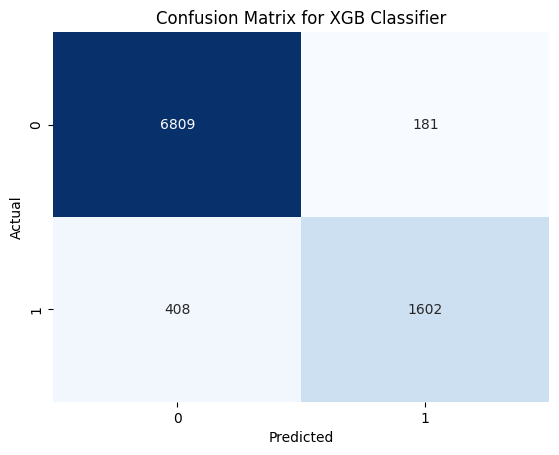

In [96]:
confusion_matrix_result = confusion_matrix(test_y, xgb_model_predictions)
sns.heatmap(confusion_matrix_result, 
            annot=True, 
            fmt='d', 
            cmap='Blues', 
            cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for XGB Classifier')
plt.show()

the XGB classifier achives the similar result as the random forest model. where it achives a weighted average of the f1_score, recall, and precision are 0.93 or 93% it shows that the models performs very well even though there are class imbalances. However, the XGB classifier model has a better per class predicion which is shown at the classification report. So the better option is to use the XGB Classifier model

## Export Model and Encoder to Pickle

### Export the model

In [ ]:
#model export
save_cache(xgb_classifier_model, "xgb_classifier_model.pkl")

Data saved to xgb_classifier_model.pkl
Data saved to random_forest_model.pkl


### Export the Encoders

In [ ]:
save_cache(gender_enc, "gender_encoder.pkl")
save_cache(education_enc, "education_encoder.pkl")
save_cache(home_ownership_enc, "home_ownership_encoder.pkl")
save_cache(loan_intent_enc, "loan_intent_encoder.pkl")
save_cache(previous_loans_enc, "previous_loans_encoder.pkl")

Data saved to gender_encoder.pkl
Data saved to education_encoder.pkl
Data saved to home_ownership_encoder.pkl
Data saved to loan_intent_enc.pkl
Data saved to previous_loans_encoder.pkl
